In [93]:
from dataset import CustomDataset
import os
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from models import ConvAutoencoder, UNet, VAE
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import piq  # For SSIM (metric)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transforms = ToTensor()
train_dataset = CustomDataset(
    "transcendingvictor/watermark1_flowers_dataset",
    "transcendingvictor/original_flowers_dataset",
    "train",
    transforms,
)
val_dataset = CustomDataset(
    "transcendingvictor/watermark1_flowers_dataset",
    "transcendingvictor/original_flowers_dataset",
    "test",
    transforms,
)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
print(f"All dataset loaded!")

Found cached dataset parquet (C:/Users/trans/.cache/huggingface/datasets/transcendingvictor___parquet/transcendingvictor--watermark1_flowers_dataset-f9def8f8a624b6bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (C:/Users/trans/.cache/huggingface/datasets/transcendingvictor___parquet/transcendingvictor--original_flowers_dataset-956e69891c59d65c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (C:/Users/trans/.cache/huggingface/datasets/transcendingvictor___parquet/transcendingvictor--watermark1_flowers_dataset-f9def8f8a624b6bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (C:/Users/trans/.cache/huggingface/datasets/transcendingvictor___parquet/transcendingvictor--original_flowers_dataset-956e69891c59d65c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [11]:
print(f"Validation dataset; {len(val_dataset)} images")
print(f"Training dataset; {len(train_dataset)} images")
print(f"Each element of the val_dataset has {len(val_dataset[0])} elements") # 2 (watermarked, original)
print(f"Each image is of size: {val_dataset[0][0].size()}") # torch.Size([3, 500, 500])

Validation dataset; 1020 images
Training dataset; 7169 images
Each element of the val_dataset has 2 elements
Each image is of size torch.Size([3, 500, 500])


In [20]:
def visualize_reconstruction(dataset, model, index, device=device, model_type = "CAE"):
    """
    Visualize the watermarked and reconstructed images from the validation dataset.

    Parameters:
    - dataset: torchvision dataset.
    - model: PyTorch model (autoencoder).
    - index: int, the index of the image in the dataset to visualize.
    - device: str, the device model is running on.
    """
    # Get the watermarked image and the original image from the dataset
    watermarked_img, original_img = dataset[index]
    
    # Move the image to the device and add a batch dimension
    watermarked_img = watermarked_img.unsqueeze(0).to(device)
    
    # Forward pass through the model to get the reconstructed image
    model.eval()
    with torch.no_grad():
        if model_type == "CAE":
            reconstructed_img = model(watermarked_img).cpu().squeeze(0)
        if model_type == "VAE":
            reconstructed_img, _, _ = model(watermarked_img)
            reconstructed_img = reconstructed_img.cpu().squeeze(0)
        if model_type == "diffusion":
            reconstructed_img = model(watermarked_img)
            for _ in range(9):
                reconstructed_img = model(reconstructed_img)
            reconstructed_img = reconstructed_img.cpu().squeeze(0)
    # Convert images to displayable format
    watermarked_img = watermarked_img.cpu().squeeze(0).permute(1, 2, 0)
    reconstructed_img = reconstructed_img.permute(1, 2, 0)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(watermarked_img.numpy())
    axes[0].set_title('Watermarked Image')
    axes[0].axis('off')

    axes[1].imshow(reconstructed_img.numpy())
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')

    plt.show()

Belowe are all the models along with displayed examples of reconstructed images against the watermarked ones.

At the end, a quantitative comparison of the models is provided.

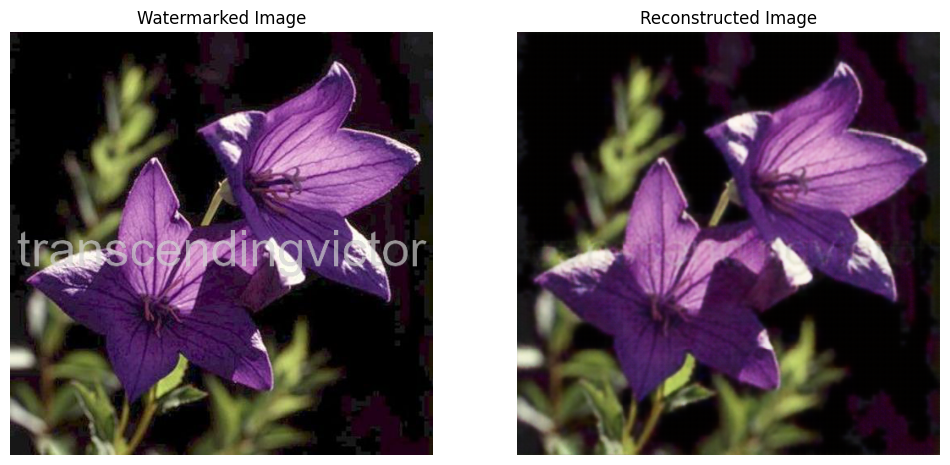

In [86]:
# Load the convolutional Autoencoder (at the end of epoch 39)
checkpoint = torch.load("checkpoints/special_checkpoints/checkpoint_CAE_epoch39.pth")
cae = ConvAutoencoder().to(device)
cae.load_state_dict(checkpoint["model_state_dict"])
cae.eval()

# Vizualize an example
index = 132  # Choose an index of the validation dataset
visualize_reconstruction(val_dataset, cae, index)

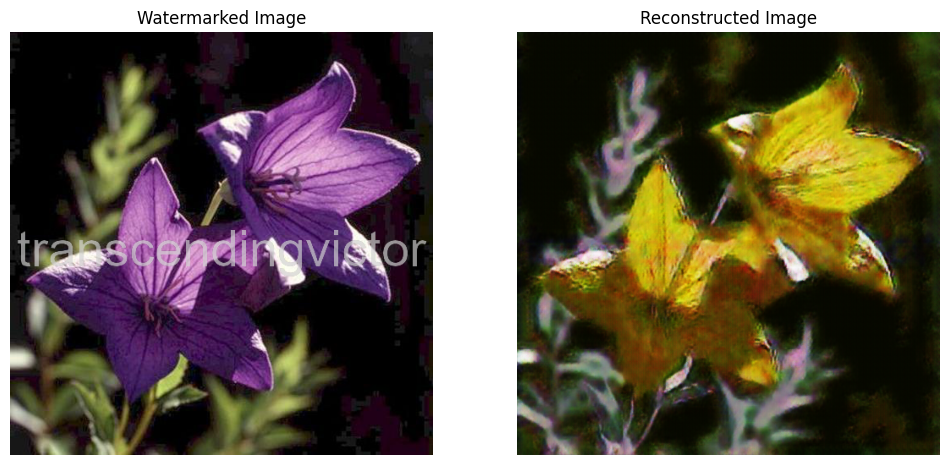

In [59]:
# Now I show the generator network at the end of the three phases of training.

# Load the convolutional generator1 (after solely trained to fool the discriminator)
checkpoint = torch.load("checkpoints/special_checkpoints/checkpoint_GAN_epoch41.pth")
generator1  = ConvAutoencoder().to(device)
generator1.load_state_dict(checkpoint["generator_state_dict"])
generator1.eval()

# Vizualize an example
index = 132  # Choose an index of the validation dataset
visualize_reconstruction(val_dataset, generator1, index)

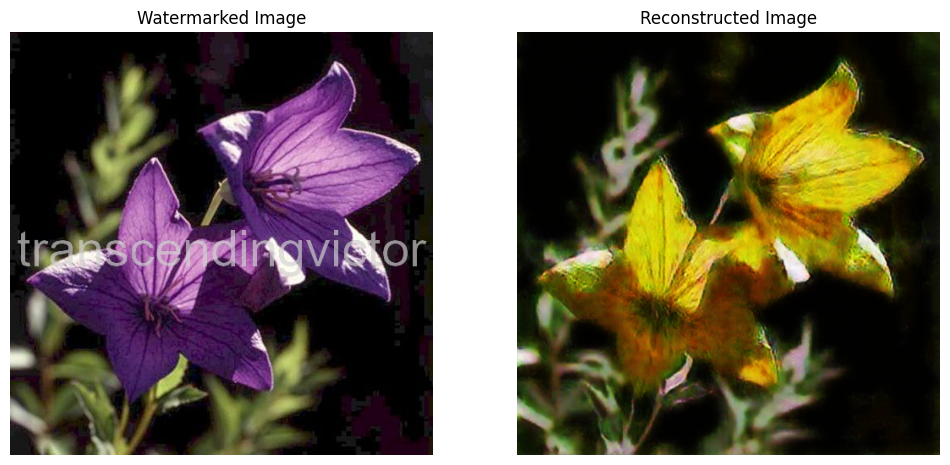

In [60]:
# Load the convolutional generator2 (after 10 epochs trained to fool the discriminator and reconstruction loss)
checkpoint = torch.load("checkpoints/special_checkpoints/checkpoint_GAN2_epoch10.pth")
generator2  = ConvAutoencoder().to(device)
generator2.load_state_dict(checkpoint["generator_state_dict"])
generator2.eval()

# Vizualize an example
index = 132  # Choose an index of the validation dataset
visualize_reconstruction(val_dataset, generator2, index)

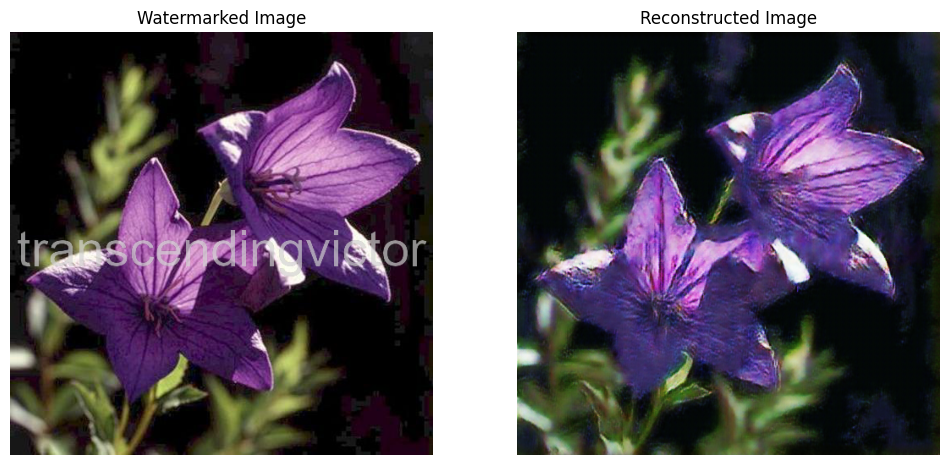

In [57]:
#BEST PERFORMANCE
# Load the convolutional generator2 (after 19 epochs trained more intensly to reconstruct and also fool the discriminator a bit)
checkpoint = torch.load("checkpoints/special_checkpoints/checkpoint_GAN3_epoch19.pth")
generator3  = ConvAutoencoder().to(device)
generator3.load_state_dict(checkpoint["generator_state_dict"])
generator3.eval()

# Vizualize an example
index = 132  # Choose an index of the validation dataset
visualize_reconstruction(val_dataset, generator3, index)

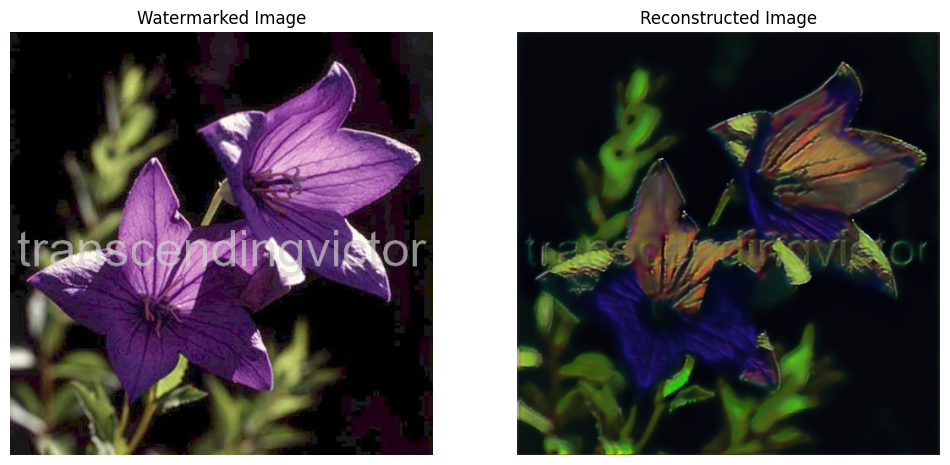

In [67]:
# Load the Diffussion Model (at the end of epoch 1)
checkpoint = torch.load("checkpoints/special_checkpoints/checkpoint_diffussion_epoch1.pth")
unet = UNet().to(device)
unet.load_state_dict(checkpoint["model_state_dict"])
unet.eval()

# Vizualize an example
index = 132  # Choose an index of the validation dataset
visualize_reconstruction(val_dataset, unet, index, model_type="diffusion")

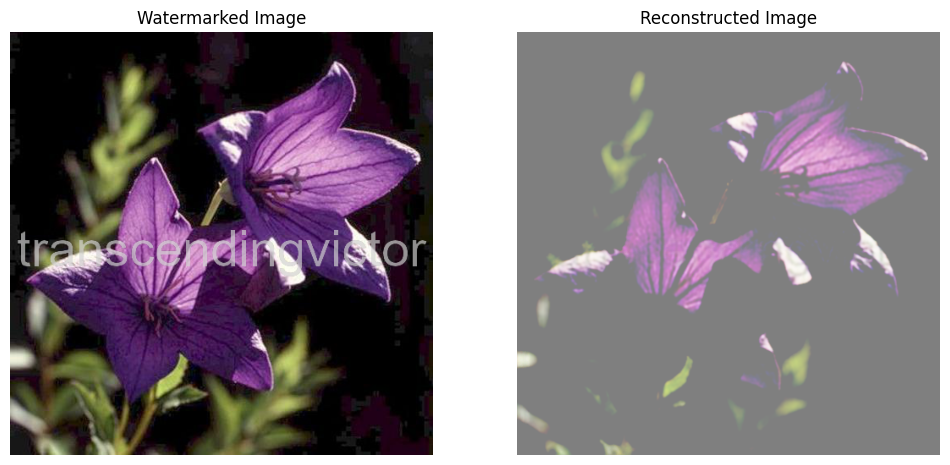

In [84]:
# Load the Variational Autoencoder Model (at the end of epoch 39 of only trained in reconstruction, not KL Loss)
checkpoint = torch.load("checkpoints/special_checkpoints/checkpoint_VAE_epoch_39.pth")
vae = VAE().to(device)
vae.load_state_dict(checkpoint["model_state_dict"])
vae.eval()

# Vizualize an example
index = 132  # Choose an index of the validation dataset  (examples 56, 120, 220, 302 work relatively good.)
visualize_reconstruction(val_dataset, vae, index, model_type="VAE")

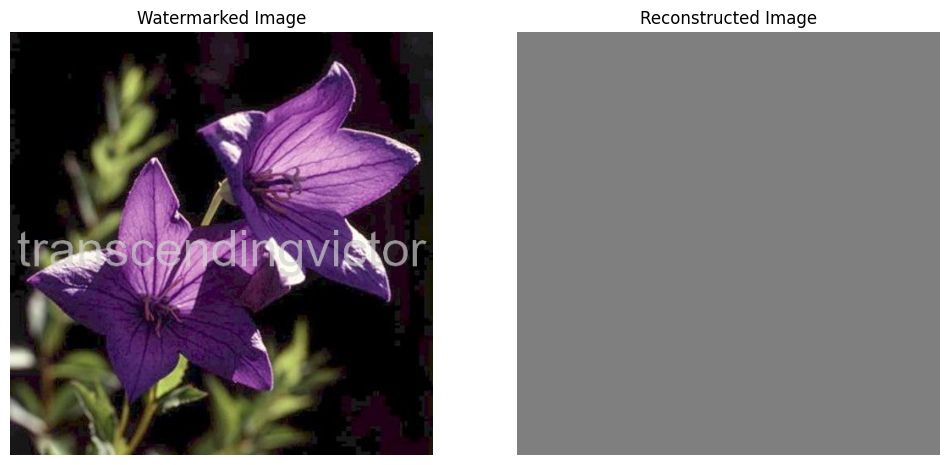

In [85]:
# Load the Variational Autoencoder Model (at the end of epoch 31 trained with KL Divergence Loss)
checkpoint = torch.load("checkpoints/special_checkpoints/checkpoint_VAE_KL_epoch_31.pth")
vae_kl = VAE().to(device)
vae_kl.load_state_dict(checkpoint["model_state_dict"])
vae_kl.eval()

# Vizualize an example
index = 132  # Choose an index of the validation dataset  (all examples are grey)
visualize_reconstruction(val_dataset, vae_kl, index, model_type="VAE")

In [95]:
# Takes around 30 seconds to calculate the metrics for the CAE
cae_mse = 0.0
cae_ssim = 0.0

with torch.no_grad():
    for watermarked_images, original_images in tqdm(
        val_loader, desc=f"CAE loss", leave=False
    ):
        # Move images to the device where the model is
        watermarked_images = watermarked_images.to(device)
        original_images = original_images.to(device)
        
        # Compute the reconstruction loss MSE and SSIM for cae
        outputs = cae(watermarked_images)
        reconstruction_loss = torch.nn.MSELoss()(outputs, original_images)
        cae_mse += reconstruction_loss.item()
        current_ssim = piq.ssim(outputs, original_images, data_range=1.0)
        cae_ssim += current_ssim.item()

average_cae_mse = cae_mse / len(val_loader)
average_cae_ssim = cae_ssim / len(val_loader)

psnr = 10 * np.log10(1.0 ** 2 / average_cae_mse)

print(f"Average MSE: {average_cae_mse}")
print(f"Average SSIM: {average_cae_ssim}")
print(f"PSNR: {psnr} dB")        

CAE loss:   0%|          | 0/64 [00:00<?, ?it/s]

Average MSE: 0.0021911658586759586
Average SSIM: 0.8669299660250545
PSNR: 26.59324747596077 dB


In [97]:
# Takes around 30 seconds to calculate the metrics for the generator3
generator3_mse = 0.0
generator3_ssim = 0.0

with torch.no_grad():
    for watermarked_images, original_images in tqdm(
        val_loader, desc=f"Generator3 loss", leave=False
    ):
        # Move images to the device where the model is
        watermarked_images = watermarked_images.to(device)
        original_images = original_images.to(device)
        
        # Compute the reconstruction loss MSE and SSIM for generator3
        outputs = generator3(watermarked_images)
        reconstruction_loss = torch.nn.MSELoss()(outputs, original_images)
        generator3_mse += reconstruction_loss.item()
        current_ssim = piq.ssim(outputs, original_images, data_range=1.0)
        generator3_ssim += current_ssim.item()

average_generator3_mse = generator3_mse / len(val_loader)
average_generator3_ssim = generator3_ssim / len(val_loader)

psnr = 10 * np.log10(1.0 ** 2 / average_generator3_mse)

print(f"Average MSE: {average_generator3_mse}")
print(f"Average SSIM: {average_generator3_ssim}")
print(f"PSNR: {psnr} dB")

Generator3 loss:   0%|          | 0/64 [00:00<?, ?it/s]

Average MSE: 0.011146715412905905
Average SSIM: 0.6329859737306833
PSNR: 19.52853086714368 dB


In [99]:
# Takes around 40 seconds to calculate the metrics for the vae
vae_mse = 0.0
vae_ssim = 0.0

with torch.no_grad():
    for watermarked_images, original_images in tqdm(
        val_loader, desc=f"VAE loss", leave=False
    ):
        # Move images to the device where the model is
        watermarked_images = watermarked_images.to(device)
        original_images = original_images.to(device)
        
        # Compute the reconstruction loss MSE and SSIM for vae
        outputs, _, _ = vae(watermarked_images)
        reconstruction_loss = torch.nn.MSELoss()(outputs, original_images)
        vae_mse += reconstruction_loss.item()
        current_ssim = piq.ssim(outputs, original_images, data_range=1.0)
        vae_ssim += current_ssim.item()

average_vae_mse = vae_mse / len(val_loader)
average_vae_ssim = vae_ssim / len(val_loader)

psnr = 10 * np.log10(1.0 ** 2 / average_vae_mse)

print(f"Average MSE: {average_vae_mse}")
print(f"Average SSIM: {average_vae_ssim}")
print(f"PSNR: {psnr} dB")

VAE loss:   0%|          | 0/64 [00:00<?, ?it/s]

Average MSE: 0.07264422124717385
Average SSIM: 0.49516144255176187
PSNR: 11.387989275501706 dB


In [100]:
# Takes around __ seconds to calculate the metrics for the unet
val_loader = DataLoader(dataset=val_dataset, batch_size=6, shuffle=False) # reload val_loader with smaller batch_size

# # Define a subset?? the indices for the subsets
# train_indices = range(200)  # First 200 examples for training
# val_indices = range(20)  # First 20 examples for validation

# # Create subset datasets
# train_subset = Subset(train_dataset, train_indices)
# val_subset = Subset(val_dataset, val_indices)

# # Create data loaders
# train_loader = DataLoader(dataset=train_subset, batch_size=16, shuffle=True)
# val_loader = DataLoader(dataset=val_subset, batch_size=16, shuffle=False)



unet_mse = 0.0
unet_ssim = 0.0

with torch.no_grad():
    for watermarked_images, original_images in tqdm(
        val_loader, desc=f"UNet loss", leave=False
    ):
        # Move images to the device where the model is
        watermarked_images = watermarked_images.to(device)
        original_images = original_images.to(device)
        
        # Compute the reconstruction loss MSE and SSIM for unet
        outputs, _, _ = unet(watermarked_images)
        reconstruction_loss = torch.nn.MSELoss()(outputs, original_images)
        unet_mse += reconstruction_loss.item()
        current_ssim = piq.ssim(outputs, original_images, data_range=1.0)
        unet_ssim += current_ssim.item()

average_unet_mse = unet_mse / len(val_loader)
average_unet_ssim = unet_ssim / len(val_loader)

psnr = 10 * np.log10(1.0 ** 2 / average_unet_mse)

print(f"Average MSE: {average_unet_mse}")
print(f"Average SSIM: {average_unet_ssim}")
print(f"PSNR: {psnr} dB")

UNet loss:   0%|          | 0/64 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\trans\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\trans\AppData\Local\Temp\ipykernel_17188\512796407.py", line 14, in <module>
    outputs, _, _ = unet(watermarked_images)
                    ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\trans\Anaconda3\envs\arena\Lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\trans\Documents\VICTOR DOCUMENTS\Victor now is doing a master\INM705 DL4Images\unwatermarking\models.py", line 149, in forward
    logits = self.outc(x)
        ^^^^^^^^^^^
  File "c:\Users\trans\Anaconda3\envs\arena\Lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Us